In [2]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

from quantdev.data import Databank
from quantdev.backtest import *
from quantdev.analysis import *
# from quantdev.trade import PortfolioManager, Position, Portfolio

from typing import Literal
import pandas as pd
import numpy as np

In [2]:
db = Databank()
# db.update_databank()
# db._update_factor_model()

##### style analysis

In [4]:
roe = get_factor('roe')
pbr = get_factor('股價淨值比')
mtm = get_factor('mtm_6m')
f = get_factor(roe+pbr+mtm)
strategy = backtesting(f>=0.99, 'QR')

In [5]:
def _calc_portfolio_style(portfolio_daily_rtn:Union[pd.DataFrame, pd.Series], model:pd.DataFrame=None, resample:Literal['YE', 'QE', 'ME', 'W-FRI']=None, window:int=None):    
    from quantdev.data import Databank
    db = Databank()
    model = db.read_dataset('factor_model').drop(['MTM6m', 'CMA'], axis=1)
    data = pd.concat([portfolio_daily_rtn, model], axis=1).dropna()
    
    if resample:
        data = data.apply(lambda df: resample_returns(df, resample))
    
    # rolling
    X = sm.add_constant(data[model.columns])
    y = data.drop(columns=model.columns)

    rolling_reg = RollingOLS(y, X, window=round(len(data)*.2) if window is None else window)
    return rolling_reg.fit().params.dropna(how='all')

    # # all
    # result = sm.OLS(y, X).fit()
    # exposure = pd.DataFrame(result.params, columns=['all']).T

    # return pd.concat([beta, exposure], axis=0)

portfolio_style = _calc_portfolio_style(strategy.daily_return)

In [6]:
from plotly.colors import sample_colorscale

# plot
def _plot_return_attribution():
    fig = make_subplots(
        rows=2, cols=1,
        specs=[
            [{"secondary_y": True}],
            [{}],
        ],
        vertical_spacing=0.05,
        horizontal_spacing=0.1,
    )

    # style analysis
    betas = portfolio_style.drop(columns=['const']).round(2)
    alpha = (1+portfolio_style['const']).cumprod()-1

    colors = sample_colorscale('Spectral', len(betas.columns))
    for i, col in enumerate(betas.columns):
        fig.add_trace(
            go.Scatter(
                x=betas.index, 
                y=betas[col], 
                name=col,
                line=dict(color=colors[i]),
            ),
            secondary_y=True,
            row=1, col=1,
        )
    
    fig.add_trace(
        go.Scatter(
            x=alpha.index, 
            y=alpha.values, 
            name='Alpha',
            line=dict(color=PlotMaster().fig_param['colors']['Light Grey'], width=2),
        ),
        secondary_y=False,
        row=1, col=1,
    )
    
    # brinson model
    brinson_model = pd.DataFrame()
    fig.add_trace(
        go.Scatter(
            x=brinson_model.index, 
            y=brinson_model.values, 
        ),
        row=2, col=1,
    )

    # adjust axes
    fig.update_yaxes(tickformat=".0%", row=1, col=1, secondary_y=False, showgrid=False)

    # position
    fig.update_xaxes(domain=[0.025, 0.875], row=1, col=1)
    fig.update_yaxes(domain=[0.5, .95], row=1, col=1)

    fig.update_xaxes(domain=[0.025, 0.875], row=2, col=1)
    fig.update_yaxes(domain=[0, 0.3], row=2, col=1)

    # titles
    fig.add_annotation(text='Style Analysis', x=0, y = 1, yshift=30, xref="x domain", yref="y domain", showarrow=False, row=1, col=1)
    fig.add_annotation(text='Brinson Model', x=0, y = 1, yshift=50, xref="x domain", yref="y domain", showarrow=False, row=2, col=1)

    # laoyout
    fig.update_layout(
        legend=dict(x=0.95, y=0.9, xanchor='left', yanchor='top', bgcolor='rgba(0,0,0,0)'),
        width= PlotMaster().fig_param['size']['w'],
        height= PlotMaster().fig_param['size']['h'],
        margin= PlotMaster().fig_param['margin'],
        template= PlotMaster().fig_param['template'],
        yaxis=dict(side='right'),
        yaxis2=dict(side='left'),
    )
    
    return fig
_plot_return_attribution()

##### Brinson model

In [8]:
db = Databank()
portfolio_df = strategy.portfolio_df
portfolio_stock_ids = portfolio_df[(portfolio_df!=0)].stack().index.get_level_values(1).unique()
benchmark_sector = db.read_dataset('stock_trading_notes',
                columns=['stock_id', 't_date', '主產業別(中)'],
                filters=[
                    ['是否為臺灣50成分股', '==', 'Y']
                ])\
                # .rename(columns={'主產業別(中)':'sector'})\
                # .assign(sector=lambda x: x['sector'].str.split(' ').str[1])

benchmark_stock_ids = benchmark_sector['stock_id'].unique()
common_stock_ids = list(set(portfolio_stock_ids) | set(benchmark_stock_ids))

portfolio_sector = db.read_dataset('stock_trading_notes',
                columns=['stock_id', 't_date', '主產業別(中)'],
                filters=[
                    ['stock_id', 'in', portfolio_stock_ids]
                ])\
                # .rename(columns={'主產業別(中)':'sector'})\
                # .assign(sector=lambda x: x['sector'].str.split(' ').str[1])

weights = db.read_dataset('stock_trading_data',
                columns=['t_date', 'stock_id', '個股市值(元)'],
                filters=[
                    ['stock_id', 'in', common_stock_ids]
                ])

# Optimize merge and groupby operations
def _calc_sector_weights(sector_data, weights_data):
    sector_weights = sector_data\
        .merge(weights_data, on=['stock_id', 't_date'], how='left')\
        .pivot_table(
            index='t_date', 
            columns='主產業別(中)',
            values='個股市值(元)',
            aggfunc='sum'
        )
    
    
    return sector_weights.div(sector_weights.sum(axis=1), axis=0)
    
benchmark_sector_weights = _calc_sector_weights(benchmark_sector, weights)
portfolio_sector_weights = _calc_sector_weights(portfolio_sector, weights)

In [ ]:
return_df = strategy.return_df
((portfolio_df != 0).astype(int) * return_df)\
    .stack().reset_index().rename(columns={'level_1':'stock_id', 0:'rtn'})

,t_date,stock_id,rtn
0,2005-08-15,0050,0.0
1,2005-08-15,01001T,0.0
2,2005-08-15,1101,-0.0
3,2005-08-15,1101A,-0.0
4,2005-08-15,1102,-0.0
...,...,...,...
8647619,2025-02-17,Y1900,-0.0
8647620,2025-02-17,Y2500,0.0
8647621,2025-02-17,Y2800,0.0
8647622,2025-02-17,Y5556,-0.0


: 

In [333]:
# Calculate market cap weighted returns for each sector
def calculate_sector_returns(sector_weights, return_df):
    # Merge returns with stock sector info and weights in one step
    sector_returns = (return_df.stack()
                     .reset_index()
                     .rename(columns={0:'rtn'})
                     .merge(portfolio_sector[['stock_id', 't_date', '主產業別(中)']], 
                           on=['stock_id', 't_date'],
                           how='left')
                     .merge(weights, 
                           on=['stock_id', 't_date'], 
                           how='left'))
    
    # Calculate weighted returns using vectorized operations
    sector_returns['weighted_returns'] = sector_returns['rtn'] * sector_returns['個股市值(元)']
    
    # Group and pivot in one step using vectorized aggregation
    sector_returns = (sector_returns
                     .groupby(['t_date', '主產業別(中)'])
                     .agg({'weighted_returns':'sum', '個股市值(元)':'sum'})
                     .eval('sector_return = weighted_returns / 個股市值(元)')
                     .reset_index()
                     .pivot(index='t_date', 
                           columns='主產業別(中)', 
                           values='sector_return'))
    
    return sector_returns

# Calculate sector returns for benchmark and portfolio
benchmark_sector_returns = calculate_sector_returns(benchmark_sector_weights, return_df)
portfolio_sector_returns = calculate_sector_returns(portfolio_sector_weights, return_df)



ValueError: "個股市值" is not a supported function

In [325]:
buy_list = strategy.buy_list

benchmark_sector = db.read_dataset('stock_trading_notes',
                columns=['stock_id', 't_date', '主產業別(中)'],
                filters=[
                    ['是否為臺灣50成分股', '==', 'Y'], 
                ]
                )

portfolio_sector = db.read_dataset('stock_trading_notes',
                columns=['stock_id', 't_date', '主產業別(中)'],
                filters=[
                    ['stock_id', 'in', buy_list[buy_list].stack().index.get_level_values(1).unique()], 
                ]
                )

weights = db.read_dataset('stock_trading_data',
                columns=['t_date', 'stock_id', '個股市值(元)'],
                filters=[
                    ['stock_id', 'in', list(set(buy_list[buy_list].stack().index.get_level_values(1).unique()) & set(benchmark_sector['stock_id'].unique()))],
                ]       
                )

benchmark_sector_weights = (
    benchmark_sector.merge(weights, on=['stock_id', 't_date'], how='left')
    .groupby(['t_date', '主產業別(中)'])['個股市值(元)']
    .sum()
    .groupby('t_date')
    .transform(lambda x: x / x.sum())
    .reset_index()
    .pivot(index='t_date', columns='主產業別(中)', values='個股市值(元)')
)

portfolio_sector_weights = (
    portfolio_sector.merge(weights, on=['stock_id', 't_date'], how='left')
    .groupby(['t_date', '主產業別(中)'])['個股市值(元)']
    .sum()
    .groupby('t_date')
    .transform(lambda x: x / x.sum())
    .reset_index()
    .pivot(index='t_date', columns='主產業別(中)', values='個股市值(元)')
)

<Axes: xlabel='t_date'>

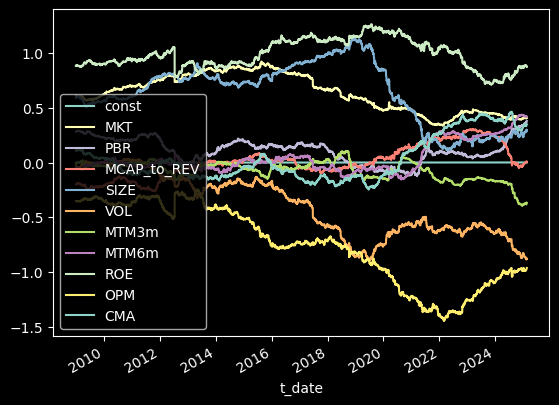

In [103]:


data = result.daily_return
model = db.read_dataset('factor_model')
data = pd.concat([data, model], axis=1)
X = sm.add_constant(data[model.columns])
y = data.drop(columns=model.columns)

# Perform rolling regression with window=12
rolling_reg = RollingOLS(y, X, window= round(len(data)*.2))
rolling_params = rolling_reg.fit().params

rolling_params.plot()

In [ ]:
def calc_sector_attr():
    pass

def calc_factor_beta():
    pass

def calc_cross_sec_factor_return():
    pass

def calc_factor_attr():
    pass

In [46]:
def _plot_factors_corr():
    """Plot factor correlation and return attribution analysis"""
    from quantdev.data import Databank
    _db = Databank()
    
    # Create subplots for different analyses
    fig = make_subplots(
        rows=2, cols=2,
        specs=[
            [{"colspan": 2}, None],
            [{}, {}],
        ],
        vertical_spacing=0.15,
        horizontal_spacing=0.1,
        subplot_titles=[
            'Rolling Factor Exposures',
            'Factor Attribution', 
            'Sector Attribution'
        ]
    )

    # 1. Rolling Factor Exposures (top plot)
    factor_model = _db.read_dataset('factor_model')
    portfolio_weights = self.portfolio_df.div(self.portfolio_df.sum(axis=1), axis=0)
    
    # Calculate rolling factor exposures
    exposures = pd.DataFrame()
    for factor in ['momentum', 'value', 'size', 'quality']:
        factor_exposure = (portfolio_weights * factor_model[factor]).sum(axis=1)
        exposures[factor] = factor_exposure.rolling(60).mean()  # 3-month rolling
    
    # Plot factor exposures
    for factor in exposures.columns:
        fig.add_trace(
            go.Scatter(
                x=exposures.index,
                y=exposures[factor],
                name=factor.capitalize(),
                mode='lines'
            ),
            row=1, col=1
        )

    # 2. Factor Attribution (bottom left)
    # Calculate factor returns contribution
    factor_attribution = exposures * factor_model[exposures.columns].mean()
    total_return = factor_attribution.sum()
    
    fig.add_trace(
        go.Bar(
            x=factor_attribution.index,
            y=factor_attribution.values,
            name='Factor Attribution',
            text=[f'{x:.1%}' for x in factor_attribution.values],
            textposition='auto',
        ),
        row=2, col=1
    )

    # 3. Sector Attribution (bottom right)
    sector_info = _db.read_dataset('stock_trading_notes', columns=['stock_id', 'date', '主產業別(中)'])
    portfolio_sectors = pd.merge(
        self.portfolio_df.stack().reset_index(),
        sector_info,
        left_on=['t_date', 'stock_id'],
        right_on=['date', 'stock_id']
    )
    
    sector_weights = portfolio_sectors.groupby('主產業別(中)')['level_2'].mean()
    sector_returns = portfolio_sectors.groupby('主產業別(中)')['level_2'].sum() * self.daily_return.mean()
    
    fig.add_trace(
        go.Bar(
            x=sector_returns.index,
            y=sector_returns.values,
            name='Sector Attribution',
            text=[f'{x:.1%}' for x in sector_returns.values],
            textposition='auto',
        ),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=self.fig_param['size']['h'],
        width=self.fig_param['size']['w'],
        margin=self.fig_param['margin'],
        template=self.fig_param['template'],
        showlegend=True,
        legend=dict(
            x=0.05, 
            y=0.95,
            xanchor='left',
            yanchor='top',
            bgcolor='rgba(0,0,0,0)'
        )
    )

    # Update axes
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True, tickformat='.1%')
    
    return fig

const    0.000446
MKT      0.550249
PBR     -0.092577
dtype: float64

<Axes: xlabel='t_date'>

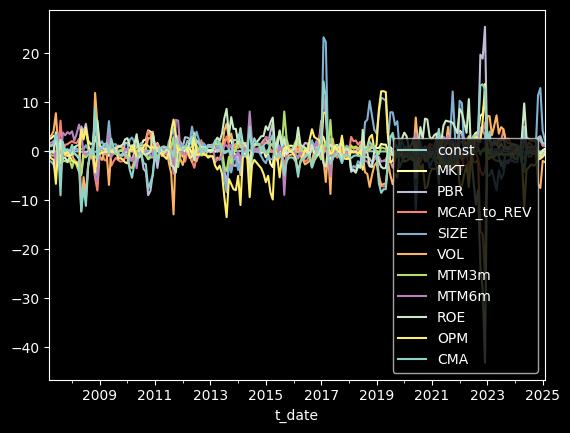

In [30]:
rolling_params.dropna().plot()

<Axes: >

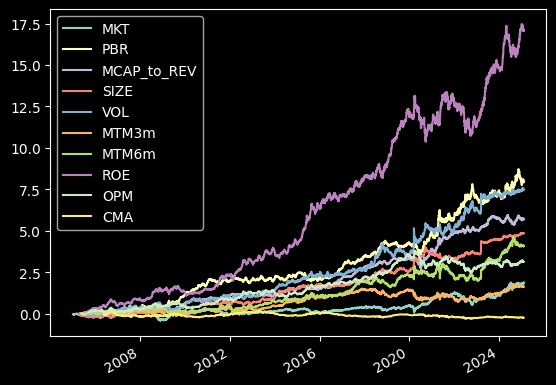

In [8]:
((1+db.read_dataset('factor_model')).cumprod()-1).plot()

In [29]:
vol = get_data('成交金額(元)').rolling(60).mean()

In [3]:
mtm_1y = get_data('mtm_1y')
mtm_6m = get_data('mtm_6m')
mtm_3m = get_data('mtm_3m')
mtm_1m = get_data('mtm_1m')
mtm_1w = get_data('mtm_1w')

In [38]:
import quantdev.backtest as bts
f = bts.get_factor(mtm_6m)
result = bts.backtesting(f>=0.9, rebalance='Q')
result.summary

,strategy,0050.TT
Annual return,15.11%,10.81%
Total return,1530.21%,727.84%
Max drawdown,-69.07%,-55.66%
Annual volatility,20.86%,19.21%
Sharpe ratio,0.72,0.56
Calmar ratio,0.22,0.19
beta,0.68,-


In [32]:
result.maemfe['return'].idxmax()

'20150105_910708'

In [39]:
calc_factor_longshort_return('營業利益率')
calc_factor_longshort_return('資產總計_yoy')

t_date
2006-05-16   -0.002751
2006-05-17   -0.005293
2006-05-18   -0.000488
2006-05-19   -0.013882
2006-05-22   -0.023281
                ...   
2025-02-03   -0.000968
2025-02-04    0.000480
2025-02-05   -0.006470
2025-02-06   -0.002615
2025-02-07   -0.002729
Length: 4609, dtype: float64

In [56]:
db = Databank()
idx_mkt_cap = db.read_dataset(
            dataset=db.find_dataset('個股市值(元)'),
            filter_date='t_date', 
            filters=[('stock_id', 'in', ['IX0001', 'IX0043'])],
        )

In [57]:
idx_mkt_cap

,date,stock_id,市場別,開盤價,最高價,最低價,收盤價,調整係數,成交量(千股),成交金額(元),...,本益比,股價淨值比,股利殖利率,現金股利率(TEJ),調整係數(除權),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ),t_date,insert_time
0,2005-01-03,IX0001,TWSE,6166.39,6183.15,6129.28,6143.12,1.0,4227307,75449754000,...,NaN,NaN,NaN,2.7698,1.0,13.3775,1.6993,1.3866,2005-01-04,2024-05-13 02:37:01.844465
1,2005-01-03,IX0043,OTC,116.05,116.36,115.02,115.27,1.0,415346,9008837000,...,NaN,NaN,NaN,1.8398,1.0,12.6629,1.3831,1.0412,2005-01-04,2024-05-13 02:37:01.844465
2,2005-01-04,IX0001,TWSE,6117.87,6129.38,6053.18,6060.46,1.0,3233436,58792130000,...,NaN,NaN,NaN,2.8076,1.0,13.1953,1.6762,1.3677,2005-01-05,2024-05-13 02:37:01.844465
3,2005-01-04,IX0043,OTC,114.83,114.86,113.28,113.64,1.0,402739,8809049000,...,NaN,NaN,NaN,1.8657,1.0,12.4770,1.3628,1.0259,2005-01-05,2024-05-13 02:37:01.844465
4,2005-01-05,IX0001,TWSE,5999.47,6030.19,5988.37,5988.37,1.0,2865117,52300990000,...,NaN,NaN,NaN,2.8414,1.0,13.0330,1.6560,1.3513,2005-01-06,2024-05-13 02:37:01.844465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,2025-02-06,IX0043,OTC,250.62,252.72,250.62,252.48,1.0,2213013,104520026000,...,NaN,NaN,NaN,2.4518,1.0,31.9649,2.8248,2.3908,2025-02-07,2025-02-11 01:04:12.518000
9884,2025-02-07,IX0001,TWSE,23289.97,23478.27,23254.17,23478.27,1.0,5980328,362285982000,...,NaN,NaN,NaN,2.3865,1.0,22.3295,2.5370,1.8681,2025-02-10,2025-02-11 01:04:12.518000
9885,2025-02-07,IX0043,OTC,252.57,255.63,252.57,255.54,1.0,2088867,105522697000,...,NaN,NaN,NaN,2.4224,1.0,32.3576,2.8596,2.4202,2025-02-10,2025-02-11 01:04:12.518000
9886,2025-02-10,IX0001,TWSE,23421.77,23448.16,23163.85,23252.14,1.0,5799480,334793847000,...,NaN,NaN,NaN,2.4097,1.0,22.1104,2.5121,1.8498,2025-02-11,2025-02-11 01:04:12.518000


In [58]:
def _calc_market_factor(mkt_idx:Literal['TR', None]=None):
    mkt_indice = {
        None:{'TWSE':{'stock_id':'IX0001', 'ch_name':'加權指數'}, 'TPEX':{'stock_id':'IX0043', 'ch_name':'OTC 指數'}},
        'TR':{'TWSE':{'stock_id':'IR0001', 'ch_name':'報酬指數'}, 'TPEX':{'stock_id':'IR0043', 'ch_name':'櫃檯報酬指'}},
    }

    # mkt rtn
    db = Databank()
    idx_ids = [v['stock_id'] for v in mkt_indice[mkt_idx].values()]
    print(idx_ids)
    idx_mkt_cap = db.read_dataset(
            dataset='stock_trading_data',
            filter_date='t_date', 
            columns=['t_date', 'stock_id', '個股市值(元)'],
            filters=[('stock_id', 'in', idx_ids)],
        )\
        .set_index(['t_date', 'stock_id'])\
        .unstack('stock_id')\
        .droplevel(0, axis=1)
    
    idx_return = db.read_dataset('stock_trading_data', 
                    columns=['date', 'stock_id', '報酬率'], 
                    filters=[('stock_id', 'in', idx_ids)])\
    .set_index(['date', 'stock_id'])\
    .unstack('stock_id')\
    .droplevel(0, axis=1)/100
    # return idx_return, idx_mkt_cap
    mkt_rtn  = (idx_return * idx_mkt_cap).sum(axis=1) / idx_mkt_cap.sum(axis=1) #pd.DataFrame((idx_return * idx_mkt_cap).sum(axis=1) / idx_mkt_cap.sum(axis=1), columns=['mkt_rtn'])

    # rf_rate
    t_date = db.read_dataset('mkt_calendar', columns=['date'], filters=[('休市原因中文說明(人工建置)','=','')]).rename(columns={'date':'t_date'})
    rf_rate = pd.merge_asof(
        t_date[t_date['t_date']<=pd.Timestamp.today()],
        db.read_dataset('rf_rate', columns=['t_date', 'bank', '定存利率_一年期_固定'], filters=[['bank', '==', '一銀']])\
        .rename(columns={'定存利率_一年期_固定':'rf_rate'})\
        [['t_date', 'rf_rate']]\
        .set_index('t_date')['rf_rate'], 
        on='t_date', 
        direction='backward'
        )\
        .assign(rf_rate=lambda df: (1 + df['rf_rate']) ** (1 / (df.groupby(df['t_date'].dt.year)['t_date'].transform('count'))) - 1)\
        .set_index('t_date')\
        ['rf_rate']\
        .ffill()
    
    return (mkt_rtn-rf_rate)

In [60]:
_calc_market_factor().dropna()

['IX0001', 'IX0043']


2005-01-04   -0.013570
2005-01-05   -0.011260
2005-01-06   -0.001303
2005-01-07   -0.007898
2005-01-10    0.000883
                ...   
2025-02-05    0.015582
2025-02-06    0.006247
2025-02-07    0.006727
2025-02-10   -0.010100
2025-02-11   -0.000625
Length: 4941, dtype: float64

In [52]:
b

stock_id,IX0001,IX0043,IX0001,IX0043,IX0001,IX0043,IX0001,IX0043,IX0001,IX0043,...,IX0001,IX0043,IX0001,IX0043,IX0001,IX0043,IX0001,IX0043,IX0001,IX0043
t_date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,2005-01-03,2005-01-03,TWSE,OTC,6166.39,116.05,6183.15,116.36,6129.28,115.02,...,1.0,1.0,13.3775,12.6629,1.6993,1.3831,1.3866,1.0412,2024-05-13 02:37:01.844465,2024-05-13 02:37:01.844465
2005-01-05,2005-01-04,2005-01-04,TWSE,OTC,6117.87,114.83,6129.38,114.86,6053.18,113.28,...,1.0,1.0,13.1953,12.4770,1.6762,1.3628,1.3677,1.0259,2024-05-13 02:37:01.844465,2024-05-13 02:37:01.844465
2005-01-06,2005-01-05,2005-01-05,TWSE,OTC,5999.47,112.80,6030.19,113.80,5988.37,112.77,...,1.0,1.0,13.0330,12.4339,1.6560,1.3607,1.3513,1.0241,2024-05-13 02:37:01.844465,2024-05-13 02:37:01.844465
2005-01-07,2005-01-06,2005-01-06,TWSE,OTC,5988.72,113.34,6002.52,113.56,5971.58,112.56,...,1.0,1.0,13.0165,12.3763,1.6539,1.3583,1.3496,1.0227,2024-05-13 02:37:01.844465,2024-05-13 02:37:01.844465
2005-01-10,2005-01-07,2005-01-07,TWSE,OTC,5990.78,113.14,6007.34,113.35,5934.83,111.86,...,1.0,1.0,12.9154,12.2674,1.6406,1.3463,1.3387,1.0137,2024-05-13 02:37:01.844465,2024-05-13 02:37:01.844465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-05,2025-02-04,2025-02-04,TWSE,OTC,22836.27,246.38,22934.31,247.68,22720.62,244.83,...,1.0,1.0,21.6843,31.1362,2.4637,2.7516,1.8141,2.3288,2025-02-11 01:04:12.518000,2025-02-11 01:04:12.518000
2025-02-06,2025-02-05,2025-02-05,TWSE,OTC,22916.38,246.34,23249.33,250.25,22916.38,246.34,...,1.0,1.0,22.0333,31.6785,2.5034,2.7995,1.8433,2.3694,2025-02-11 01:04:12.518000,2025-02-11 01:04:12.518000
2025-02-07,2025-02-06,2025-02-06,TWSE,OTC,23226.50,250.62,23348.42,252.72,23216.65,250.62,...,1.0,1.0,22.1790,31.9649,2.5199,2.8248,1.8555,2.3908,2025-02-11 01:04:12.518000,2025-02-11 01:04:12.518000


<Axes: xlabel='t_date'>

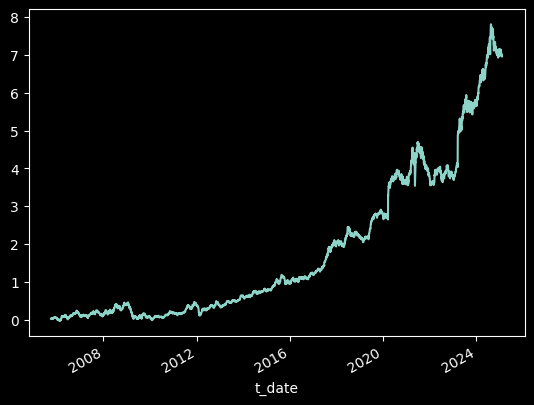

In [44]:
((calc_factor_longshort_return(get_data('mtm_6m') - get_data('mtm_1m'), rebalance='Q')+1).cumprod()-1).plot()

In [22]:
db = Databank()
db.list_columns('stock_trading_data')

['date',
 'stock_id',
 '市場別',
 '開盤價',
 '最高價',
 '最低價',
 '收盤價',
 '調整係數',
 '成交量(千股)',
 '成交金額(元)',
 '成交筆數',
 '最後揭示買價',
 '最後揭示賣價',
 '當日均價',
 '報酬率',
 '高低價差',
 '周轉率',
 '流通在外股數(千股)',
 '個股市值(元)',
 '市值比重',
 '成交金額比重',
 '本益比',
 '股價淨值比',
 '股利殖利率',
 '現金股利率(TEJ)',
 '調整係數(除權)',
 '本益比(TEJ)',
 '股價淨值比(TEJ)',
 '股價營收比(TEJ)',
 't_date',
 'insert_time']

<Axes: xlabel='t_date'>

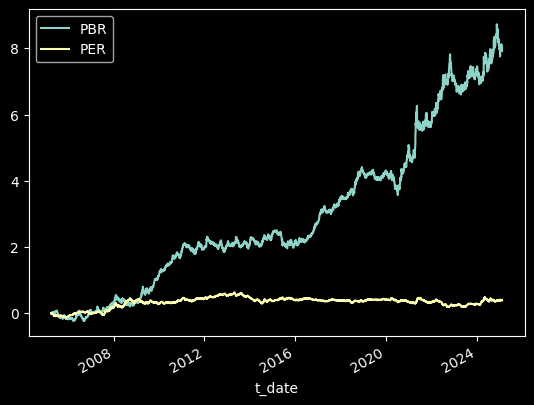

In [4]:
((1+test).cumprod()-1).plot()

In [14]:
def update_market_factor(idx_type:Literal['TR', None]=None):
    # define market indices mapping
    mkt_indice = {
        None: {
            'TWSE': {'stock_id': 'IX0001', 'ch_name': '加權指數'}, 
            'TPEX': {'stock_id': 'IX0043', 'ch_name': 'OTC 指數'}
        },
        'TR': {
            'TWSE': {'stock_id': 'IR0001', 'ch_name': '報酬指數'}, 
            'TPEX': {'stock_id': 'IR0043', 'ch_name': '櫃檯報酬指'}
        }
    }
    idx_ids = [v['stock_id'] for v in mkt_indice[idx_type].values()]

    # get market cap data
    idx_mkt_cap = db.read_dataset(
        dataset='stock_trading_data',
        columns=['date', 'stock_id', '個股市值(元)'],
        filters=[['stock_id', 'in', idx_ids]]
    ).set_index(['date', 'stock_id']).unstack('stock_id').droplevel(0, axis=1)

    # get return data 
    idx_return = db.read_dataset(
        'stock_trading_data',
        columns=['date', 'stock_id', '報酬率'],
        filters=[['stock_id', 'in', idx_ids]]
    ).set_index(['date', 'stock_id']).unstack('stock_id').droplevel(0, axis=1) / 100

    # calculate market return
    mkt_rtn = (idx_return * idx_mkt_cap).sum(axis=1) / idx_mkt_cap.sum(axis=1)

    # get risk-free rate
    rf_rate = pd.merge_asof(
        pd.DataFrame(mkt_rtn.index),
        db.read_dataset(
            'rf_rate', 
            columns=['date', 'bank', '定存利率_一年期_固定'],
            filters=[['bank', '==', '一銀']]
        ).rename(columns={'定存利率_一年期_固定': 'rf_rate'})[['date', 'rf_rate']].set_index('date')['rf_rate'],
        on='date',
        direction='backward'
    ).assign(
        rf_rate=lambda df: (1 + df['rf_rate']) ** (1 / df.groupby(df['date'].dt.year)['date'].transform('count')) - 1
    ).set_index('date')['rf_rate'].ffill()

    # calculate cumulative excess return
    return ((1 + mkt_rtn - rf_rate).cumprod() - 1).shift(-1).rename_axis('t_date')

In [15]:
update_market_factor()

t_date
2005-01-03   -0.013420
2005-01-04   -0.024522
2005-01-05   -0.025793
2005-01-06   -0.033487
2005-01-07   -0.032633
                ...   
2025-02-12    1.784920
2025-02-13    1.755969
2025-02-14    1.795299
2025-02-17    1.813879
2025-02-18         NaN
Length: 4950, dtype: float64

In [ ]:
def _update_value_factor():
    # get value factor data
    value_factor = db.read_dataset(
        '股價淨值比',
        columns=['t_date', 'stock_id', '股價淨值比'],
        filters=[['stock_id', 'in', idx_ids]]
    )

In [12]:
roe = bts.get_factor('roe')
test = bts.backtesting(roe>0.99, 'QR', benchmark=['0050'], stop_loss=-0.7, stop_at='intraday')